# Setup Env

In [1]:
!pip install fastai --upgrade -q
from fastai.vision.all import *
# from fastai.callback.cutmix import *

!pip install wwf -q
!pip install timm -q
from wwf.vision.timm import *

# !pip install efficientnet_pytorch -q
# from efficientnet_pytorch import EfficientNet

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

pytorch-lightning 0.9.0 requires tensorboard==2.2.0, but you'll have tensorboard 2.3.0 which is incompatible.
kornia 0.4.0 requires torch<1.7.0,>=1.6.0, but you'll have torch 1.12.1 which is incompatible.
allennlp 1.1.0 requires torch<1.7.0,>=1.6.0, but you'll have torch 1.12.1 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Import data

In [2]:
path = Path('../input/planets-dataset/planet/planet')

In [4]:
train_df = pd.read_csv(path/'train_classes.csv')
train_df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [5]:
def get_x(r):
    return path/'train-jpg'/(r['image_name']+'.jpg')

def get_y(r):
    return r['tags'].split()

def get_data(size=224,bs=64,data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                       splitter=RandomSplitter(seed=42),
                       get_x=get_x, 
                       get_y=get_y,
                       item_tfms = Resize(size),
                       batch_tfms = [*aug_transforms(flip_vert=True,max_warp=0),
                                     Normalize.from_stats(*imagenet_stats)]
                      )
    return dblock.dataloaders(data_df,bs=bs)

In [6]:
dls = get_data(300,40)

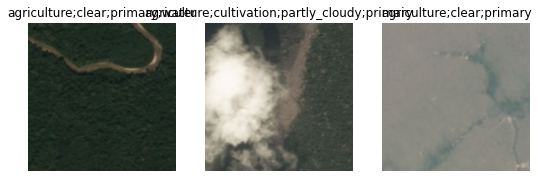

In [7]:
dls.show_batch(nrows=1, ncols=3)

# Training

In [8]:
# f2macro = FBetaMulti(beta=2,average='macro')
# f2micro = FBetaMulti(beta=2,average='micro')
f2samples = FBetaMulti(beta=2,average='samples',thresh=0.2)

# model = EfficientNet.from_pretrained('efficientnet-b7', get_c(dls))
metrics = [partial(accuracy_multi, thresh=0.2), f2samples]
cbs = [MixUp]

In [9]:
# learn = cnn_learner(dls, resnet50, metrics=metrics, cbs=cbs)
# learn = Learner(dls, model, metrics=metrics, f2samples], cbs=cbs)
# learn = Learner(dls, model, metrics=metrics, loss_func=LabelSmoothingCrossEntropy(), cbs=cbs)

learn = timm_learner(dls, 'efficientnet_b3', metrics=metrics, cbs=cbs)

# learn.lr_find()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


In [10]:
learn.fine_tune(12, base_lr=3e-2, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.181375,6.646544,0.931003,0.854205,08:35
1,0.170769,0.668972,0.930211,0.879843,07:01
2,0.170579,0.279632,0.940973,0.900892,07:06
3,0.172058,564.392578,0.939832,0.903728,07:07


epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.148337,991.743530,0.949715,0.910088,09:06
1,0.154303,357.815979,0.955005,0.914082,09:04
2,0.150053,40.073174,0.947978,0.912028,09:08
3,0.146959,5.917771,0.954423,0.919970,09:06
4,0.146371,1.517077,0.957148,0.918890,09:05
5,0.144876,0.173307,0.953413,0.919740,09:06
6,0.138671,13.160541,0.951677,0.919525,09:04
7,0.134105,0.148370,0.954315,0.921733,09:05
8,0.133700,116.226410,0.955848,0.921599,09:05
9,0.131231,0.167297,0.955869,0.924182,09:06


In [ ]:
# preds,targs = learn.get_preds()

# xs = torch.linspace(0.05,0.95,29)
# accs = [f2_score(preds, targs, threshold=i) for i in xs]
# plt.plot(xs,accs);

# Submission with TTA

In [22]:
file_path = Path('../input/planets-dataset/test-jpg-additional/test-jpg-additional')
test_path = Path('../input/planets-dataset/planet/planet/test-jpg')
submission_df = pd.read_csv(path/'sample_submission.csv')
testing_path = (submission_df['image_name'] + '.jpg').apply(lambda x: test_path/x if x.startswith('test') else file_path/x)

def prediction(filename='submission.csv', tta=False):
    tst_dl = learn.dls.test_dl(testing_path)
    if tta:
        predictions = learn.tta(dl = tst_dl)
    else:
        predictions = learn.get_preds(dl = tst_dl)
    predlist = [' '.join(learn.dls.vocab[i]) for i in (predictions[0] > 0.2)]

    df = submission_df
    df['tags'] = predlist

    df.to_csv(filename, index=False)
    return df

In [23]:
prediction('submission_tta.csv', tta=True)

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,agriculture clear cultivation primary
4,test_4,partly_cloudy primary
...,...,...
61186,file_9995,cloudy
61187,file_9996,agriculture clear primary water
61188,file_9997,clear primary road water
61189,file_9998,cloudy
